## imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import xgboost as xgb
import lightgbm as lgb
import category_encoders as cat_ed
import gc, mlcrate, glob

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from IPython.display import display
from catboost import CatBoostClassifier
from scipy.cluster import hierarchy as hc
from collections import Counter

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# will ignore all warning from sklearn, seaborn etc..
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.option_context("display.max_rows", 20);
pd.option_context("display.max_columns", 100);

In [3]:
PATH = os.getcwd();
PATH

'D:\\Github\\fastai\\courses\\ml1'

In [167]:
# df_raw_1 = pd.read_csv(f'{PATH}\\AV_Stud_2\\train.csv', low_memory=False)
# df_test_1 = pd.read_csv(f'{PATH}\\AV_Stud_2\\test.csv', low_memory=False)

# df_raw['last_new_job'] = df_raw_1['last_new_job']
# df_test['last_new_job'] = df_test_1['last_new_job']

# del df_raw_1, df_test_1

In [27]:
# df_raw = pd.read_csv(f'{PATH}\\AV_Stud_2\\train.csv', low_memory=False)
# df_test = pd.read_csv(f'{PATH}\\AV_Stud_2\\test.csv', low_memory=False)

# stack_train = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_train.csv')
# stack_test = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_test.csv')

# stack_train_2 = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_train_2.csv')
# stack_test_2 = pd.read_csv(f'{PATH}\\AV_Stud_2\\stack_test_2.csv')
train_67 = np.load(f'{PATH}\\AV_Stud_2\\train_67.npy')
test_67 = np.load(f'{PATH}\\AV_Stud_2\\test_67.npy')

# drop enrollee id

In [10]:
target = stack_train.target
stack_train.drop('target', axis=1, inplace=True)

## cleaning a bit

In [5]:
target = df_raw.target.values
drop_col = ['enrollee_id']
df_raw.drop(drop_col, axis=1,inplace=True)
df_test.drop(drop_col, axis=1, inplace=True)

In [6]:
cols = ['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'enrolled_university_degree',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target']
df_raw.columns = cols
df_test.columns = cols[:-1]

In [7]:
df_raw.head(2)

,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university_degree,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0


In [8]:
for c in df_raw.columns:
    n = df_raw[c].nunique()
    print(c)
    if n <= 8:
        print(n, sorted(df_raw[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(120 * '-')

city
123
------------------------------------------------------------------------------------------------------------------------
city_development_index
93
------------------------------------------------------------------------------------------------------------------------
gender
3 [('Female', 1188), ('Male', 12884), ('Other', 189)]
------------------------------------------------------------------------------------------------------------------------
relevent_experience
2 [('Has relevent experience', 13596), ('No relevent experience', 4763)]
------------------------------------------------------------------------------------------------------------------------
enrolled_university
3 [('Full time course', 3187), ('Part time course', 1171), ('no_enrollment', 13659)]
------------------------------------------------------------------------------------------------------------------------
enrolled_university_degree
5 [('Graduate', 10769), ('High School', 2032), ('Masters', 4319), ('Phd', 

## city and city_dev col's

In [10]:
#clean city split
df_raw['city'] = df_raw['city'].str.split('_',expand=True)[1]
df_raw['city'] = df_raw['city'].astype('int32')

df_test['city'] = df_test['city'].str.split('_',expand=True)[1]
df_test['city'] = df_test['city'].astype('int32')

In [28]:
df_raw['is_city_in_103_21_116_114_160'] = np.full(df_raw.shape[0], 0)
my_query = df_raw[(df_raw['city'] == 103)|(df_raw['city'] == 21) | (df_raw['city'] == 16) | (df_raw['city'] == 114) | (df_raw['city'] == 160)].index
df_raw.iloc[my_query, -1] = 1

In [30]:
df_test['is_city_in_103_21_116_114_160'] = np.full(df_test.shape[0], 0)

my_query = df_test[(df_test['city'] == 103)|(df_test['city'] == 21) | (df_test['city'] == 16) | (df_test['city'] == 114) | (df_test['city'] == 160)].index
df_test.iloc[my_query, -1] = 1

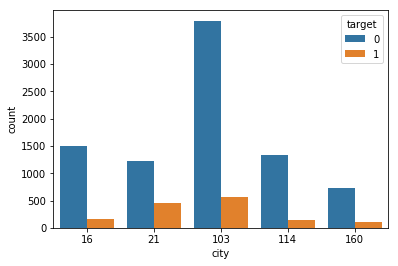

In [32]:
sns.countplot(df_raw[(df_raw['city'] == 103)|(df_raw['city'] == 21) | (df_raw['city'] == 16) |\
       (df_raw['city'] == 114) | (df_raw['city'] == 160)]['city'], data=df_raw, hue='target');

In [43]:
df_raw['city_development_index'].value_counts(ascending=False).head(20).cumsum()

0.920     5185
0.624     6857
0.910     8511
0.926     9983
0.698    10638
0.897    11262
0.939    11806
0.855    12261
0.924    12579
0.804    12892
0.884    13173
0.887    13444
0.754    13708
0.913    13925
0.899    14119
0.802    14307
0.925    14485
0.893    14660
0.878    14816
0.743    14968
Name: city_development_index, dtype: int64

In [44]:
df_raw['is_dev_20'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index<=.2').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_21_30'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.21 & city_development_index<=.3').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_31_40'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.31 & city_development_index<=.4').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_41_50'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.41 & city_development_index<=.5').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_51_60'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.51 & city_development_index<=.6').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_61_70'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.61 & city_development_index<=.7').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_71_80'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.71 & city_development_index<=.8').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_81_90'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.81 & city_development_index<=.9').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_dev_91'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('city_development_index>=.91').index
df_raw.iloc[my_query, -1] = 1

In [45]:
df_test['is_dev_20'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index<=.2').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_21_30'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.21 & city_development_index<=.3').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_31_40'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.31 & city_development_index<=.4').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_41_50'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.41 & city_development_index<=.5').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_51_60'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.51 & city_development_index<=.6').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_61_70'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.61 & city_development_index<=.7').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_71_80'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.71 & city_development_index<=.8').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_81_90'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.81 & city_development_index<=.9').index
df_test.iloc[my_query, -1] = 1

df_test['is_dev_91'] = np.zeros(df_test.shape[0])
my_query = df_test.query('city_development_index>=.91').index
df_test.iloc[my_query, -1] = 1

In [49]:
df_raw.shape, df_test.shape

((18359, 23), (15021, 22))

## company_size col

In [56]:
# merge both df's
df_raw['min_company_size'] = np.full(df_raw.shape[0], -1)
df_raw['max_company_size'] = np.full(df_raw.shape[0], -1)

my_query = df_raw[df_raw['company_size'] =='<10'].index
df_raw.iloc[my_query, -2] = 0
df_raw.iloc[my_query, -1] = 9

my_query = df_raw[df_raw['company_size'] =='10/49'].index
df_raw.iloc[my_query, -2] = 10
df_raw.iloc[my_query, -1] = 49

my_query = df_raw[df_raw['company_size'] =='50-99'].index
df_raw.iloc[my_query, -2] = 50
df_raw.iloc[my_query, -1] = 99

my_query = df_raw[df_raw['company_size'] =='100-500'].index
df_raw.iloc[my_query, -2] = 100
df_raw.iloc[my_query, -1] = 500

my_query = df_raw[df_raw['company_size'] =='500-999'].index
df_raw.iloc[my_query, -2] = 500
df_raw.iloc[my_query, -1] = 999

my_query = df_raw[df_raw['company_size'] =='1000-4999'].index
df_raw.iloc[my_query, -2] = 1000
df_raw.iloc[my_query, -1] = 4999

my_query = df_raw[df_raw['company_size'] =='5000-9999'].index
df_raw.iloc[my_query, -2] = 5000
df_raw.iloc[my_query, -1] = 9999

my_query = df_raw[df_raw['company_size'] =='10000+'].index
df_raw.iloc[my_query, -2] = 10000
df_raw.iloc[my_query, -1] = 15000

########################################################################

df_test['min_company_size'] = np.full(df_test.shape[0], -1)
df_test['max_company_size'] = np.full(df_test.shape[0], -1)

my_query = df_test[df_test['company_size'] =='<10'].index
df_test.iloc[my_query, -2] = 0
df_test.iloc[my_query, -1] = 9

my_query = df_test[df_test['company_size'] =='10/49'].index
df_test.iloc[my_query, -2] = 10
df_test.iloc[my_query, -1] = 49

my_query = df_test[df_test['company_size'] =='50-99'].index
df_test.iloc[my_query, -2] = 50
df_test.iloc[my_query, -1] = 99

my_query = df_test[df_test['company_size'] =='100-500'].index
df_test.iloc[my_query, -2] = 100
df_test.iloc[my_query, -1] = 500

my_query = df_test[df_test['company_size'] =='500-999'].index
df_test.iloc[my_query, -2] = 500
df_test.iloc[my_query, -1] = 999

my_query = df_test[df_test['company_size'] =='1000-4999'].index
df_test.iloc[my_query, -2] = 1000
df_test.iloc[my_query, -1] = 4999

my_query = df_test[df_test['company_size'] =='5000-9999'].index
df_test.iloc[my_query, -2] = 5000
df_test.iloc[my_query, -1] = 9999

my_query = df_test[df_test['company_size'] =='10000+'].index
df_test.iloc[my_query, -2] = 10000
df_test.iloc[my_query, -1] = 15000

# df_raw.drop('company_size', axis=1, inplace=True)
# df_test.drop('company_size', axis=1, inplace=True)

# fill na's now wrt to exp level (to do) ####################################################

#df_raw['company_size'].fillna(df_raw.groupby('experience')['company_size'].tranform('median'))
drop_col.append('company_size')

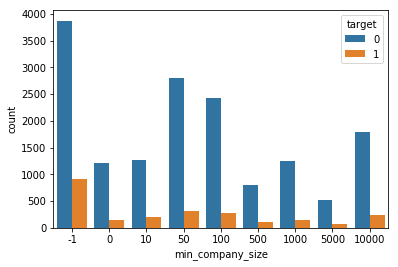

In [57]:
sns.countplot(data=df_raw,hue='target', x = 'min_company_size')

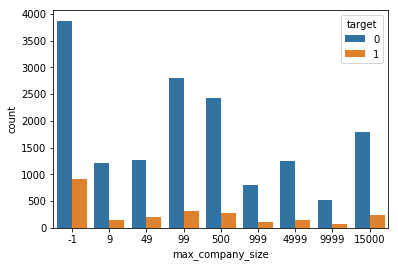

In [58]:
sns.countplot(data=df_raw,hue='target', x = 'max_company_size')

In [ ]:
# df_raw['company_size'].str.split('-', expand=True)

In [ ]:
# df_raw[df_raw['company_size'] =='10/49']['company_size'].str.split('/', expand=True)[1]

## last_new_job col

In [62]:
df_raw['last_new_job'].replace('>4',5, inplace = True)
df_raw['last_new_job'].replace('never',0, inplace = True)
df_raw['last_new_job'] = df_raw['last_new_job'].astype('float32')

df_test['last_new_job'].replace('>4',5, inplace = True)
df_test['last_new_job'].replace('never',0, inplace = True)
df_test['last_new_job'] = df_test['last_new_job'].astype('float32')

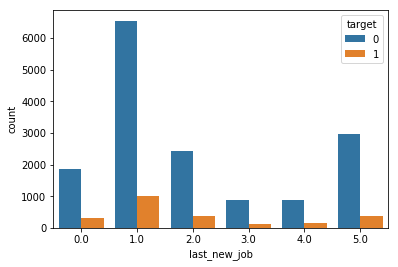

In [63]:
sns.countplot(df_raw['last_new_job'], hue='target', data=df_raw)

In [265]:
df_test['last_new_job'].fillna(method='ffill', inplace=True)

In [64]:
df_raw['last_new_job'].fillna(method='ffill', inplace=True)
df_test['last_new_job'].fillna(method='ffill', inplace=True)

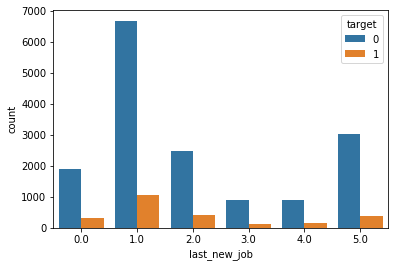

In [65]:
sns.countplot(df_raw['last_new_job'], hue='target', data=df_raw)

## experience col

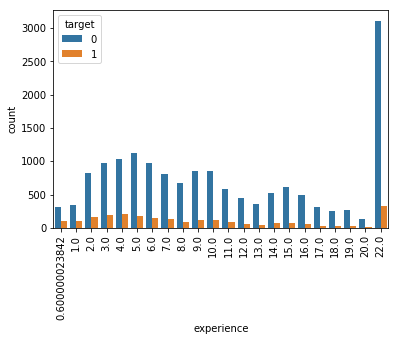

In [77]:
plt.xticks(rotation=90)
sns.countplot('experience', data=df_raw, hue='target',);

In [73]:
df_raw['experience'].replace('>20',22, inplace = True)
df_test['experience'].replace('>20',22, inplace = True)

df_raw['experience'].replace('<1',.6, inplace = True)
df_test['experience'].replace('<1',.6, inplace = True)

df_raw['experience'] = df_raw['experience'].astype('float32')
df_test['experience'] = df_test['experience'].astype('float32')

In [79]:
df_raw['experience'].fillna(method='ffill',inplace=True)
df_test['experience'].fillna(method='ffill',inplace=True)

## company_type col

In [118]:
df_raw['is_startup'] = np.full(df_raw.shape[0], 0)
my_query = df_raw[(df_raw['company_type'] == 'Funded Startup' )|(df_raw['company_type'] == 'Early Stage Startup')].index
df_raw.iloc[my_query, -1] = 1

df_test['is_startup'] = np.full(df_test.shape[0], 0)
my_query = df_test[(df_test['company_type'] == 'Funded Startup' )|(df_test['company_type'] == 'Early Stage Startup')].index
df_test.iloc[my_query, -1] = 1

In [121]:
df_raw['is_ltd'] = np.full(df_raw.shape[0], 0)
my_query = df_raw[(df_raw['company_type'] == 'Pvt Ltd' )|(df_raw['company_type'] == 'Public Sector')].index
df_raw.iloc[my_query, -1] = 1

df_test['is_ltd'] = np.full(df_test.shape[0], 0)
my_query = df_test[(df_test['company_type'] == 'Pvt Ltd' )|(df_test['company_type'] == 'Public Sector')].index
df_test.iloc[my_query, -1] = 1

In [151]:
df_raw.isnull().sum().sort_values(ascending=False).head()/len(df_raw)

company_size                  0.260308
gender                        0.223215
major_discipline              0.154584
enrolled_university_degree    0.024892
enrolled_university           0.018628
dtype: float64

In [149]:
df_raw['company_type'].fillna(value='Unknown', axis=0, inplace=True)
df_test['company_type'].fillna(value='Unknown', axis=0, inplace=True)

## gender

In [165]:
df_raw.isnull().sum().sort_values(ascending=False).head()/len(df_raw)

company_size                  0.260308
gender                        0.223215
major_discipline              0.154584
enrolled_university_degree    0.024892
enrolled_university           0.018628
dtype: float64

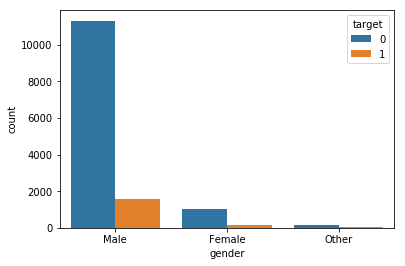

In [161]:
sns.countplot(df_raw['gender'],data=df_raw, hue='target');

In [178]:
df_raw['gender'].value_counts(normalize=True)

Male       0.701781
Unknown    0.223215
Female     0.064709
Other      0.010295
Name: gender, dtype: float64

In [175]:
df_raw1 = df_raw.copy()
df_test1 = df_test.copy()

In [176]:
df_raw['gender'].fillna(value='Unknown', axis=0, inplace=True)
df_test['gender'].fillna(value='Unknown', axis=0, inplace=True)

In [182]:
df_raw.head(2)

,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university_degree,major_discipline,experience,company_size,company_type,...,is_dev_41_50,is_dev_51_60,is_dev_61_70,is_dev_71_80,is_dev_81_90,is_dev_91,min_company_size,max_company_size,is_startup,is_ltd
0,149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3.0,100-500,Pvt Ltd,...,0.0,0.0,1.0,0.0,0.0,0.0,100,500,0,1
1,83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14.0,<10,Funded Startup,...,0.0,0.0,0.0,0.0,0.0,1.0,0,9,1,0


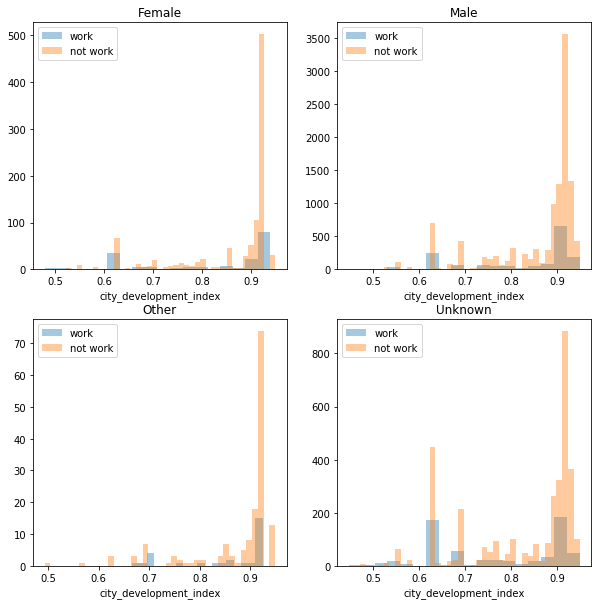

In [197]:
survived = 'work'
not_survived = 'not work'
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10, 10))

women = df_raw[df_raw['gender']=='Female']
men = df_raw[df_raw['gender']=='Male']
other = df_raw[df_raw['gender']== 'Other']
unknown = df_raw[df_raw['gender']== 'Unknown']

ax = sns.distplot(women[women['target']==1].city_development_index, bins=18, label = survived, ax = axes[0][0], kde =False)
ax = sns.distplot(women[women['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[0][0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['target']==1].city_development_index, bins=18, label = survived, ax = axes[0][1], kde = False)
ax = sns.distplot(men[men['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[0][1], kde = False)
ax.legend()
ax.set_title('Male')

ax = sns.distplot(other[other['target']==1].city_development_index, bins=18, label = survived, ax = axes[1][0], kde =False)
ax = sns.distplot(other[other['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[1][0], kde =False)
ax.legend()
ax.set_title('Other')

ax = sns.distplot(unknown[unknown['target']==1].city_development_index, bins=18, label = survived, ax = axes[1][1], kde =False)
ax = sns.distplot(unknown[unknown['target']==0].city_development_index, bins=40, label = not_survived, ax = axes[1][1], kde =False)
ax.legend()
_ = ax.set_title('Unknown')

## major discipline

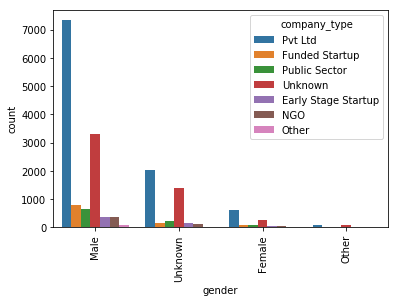

In [177]:
plt.xticks(rotation=90)
sns.countplot('gender', data=df_raw, hue='company_type')

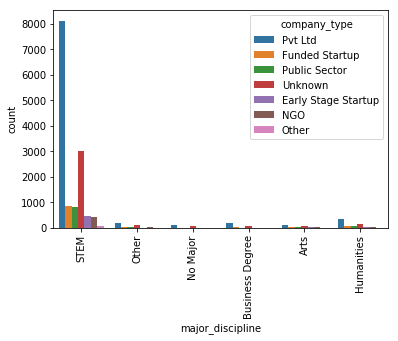

In [180]:
plt.xticks(rotation=90)
sns.countplot('major_discipline', data=df_raw, hue='company_type')

In [261]:
df_raw['unaffliated_college'] = np.zeros(df_raw.shape[0])
df_test['unaffliated_college'] = np.zeros(df_test.shape[0])

for i in ['Phd', 'Graduate', 'Masters', 'High School', 'Primary School']:

    my_query = df_raw[(df_raw['enrolled_university'] == 'no_enrollment') & (df_raw['enrolled_university_degree'] == i)].index
    df_raw.iloc[my_query, -1] = 1
    
    my_query = df_test[(df_test['enrolled_university'] == 'no_enrollment') & (df_test['enrolled_university_degree'] == i)].index
    df_test.iloc[my_query, -1] = 1

df_raw['enroll_type__enroll_deg__major_in'] = df_raw.enrolled_university+'_'+df_raw.enrolled_university_degree\
                                                +'_'+df_raw.major_discipline
df_test['enroll_type__enroll_deg__major_in'] = df_test.enrolled_university+'_'+df_test.enrolled_university_degree\
                                                +'_'+df_test.major_discipline
    
df_raw['gender__major_in'] = df_raw.gender+'_'+df_raw.major_discipline
df_test['gender__major_in'] = df_test.gender+'_'+df_test.major_discipline

df_raw['enroll_deg__major_in'] = df_raw.enrolled_university_degree+'_'+df_raw.major_discipline
df_test['enroll_deg__major_in'] = df_test.enrolled_university_degree+'_'+df_test.major_discipline
    
df_raw['city_dev__max_comp_siz'] = df_raw.city.astype(str)+'_'+df_raw.max_company_size.astype(str)
df_test['city_dev__max_comp_siz'] = df_test.city.astype(str)+'_'+df_test.max_company_size.astype(str)


In [224]:
for i in ['Phd', 'Graduate', 'Masters', 'High School', 'Primary School'] : # enrolled_university_degree
    for j in ['Arts', 'Business Degree', 'Other', 'STEM', 'Humanities', 'No Major']: #major discipline
        print(i,'&&',j,'\nTrain-', df_raw[(df_raw['major_discipline'] == j ) & (df_raw['enrolled_university'] == 'no_enrollment') & (df_raw['enrolled_university_degree'] == i)].shape[0], \
             'Test-',df_test[(df_raw['major_discipline'] == j ) & (df_test['enrolled_university'] == 'no_enrollment') & (df_test['enrolled_university_degree'] == i)].shape[0])

Phd && Arts 
Train- 3 Test- 3
Phd && Business Degree 
Train- 5 Test- 9
Phd && Other 
Train- 5 Test- 6
Phd && STEM 
Train- 378 Test- 276
Phd && Humanities 
Train- 23 Test- 18
Phd && No Major 
Train- 0 Test- 2
Graduate && Arts 
Train- 179 Test- 88
Graduate && Business Degree 
Train- 179 Test- 111
Graduate && Other 
Train- 197 Test- 119
Graduate && STEM 
Train- 6994 Test- 4924
Graduate && Humanities 
Train- 391 Test- 252
Graduate && No Major 
Train- 153 Test- 81
Masters && Arts 
Train- 32 Test- 33
Masters && Business Degree 
Train- 75 Test- 45
Masters && Other 
Train- 76 Test- 64
Masters && STEM 
Train- 3172 Test- 2152
Masters && Humanities 
Train- 203 Test- 106
Masters && No Major 
Train- 23 Test- 39
High School && Arts 
Train- 0 Test- 12
High School && Business Degree 
Train- 0 Test- 14
High School && Other 
Train- 0 Test- 14
High School && STEM 
Train- 0 Test- 628
High School && Humanities 
Train- 0 Test- 39
High School && No Major 
Train- 0 Test- 10
Primary School && Arts 
Train- 0 Te

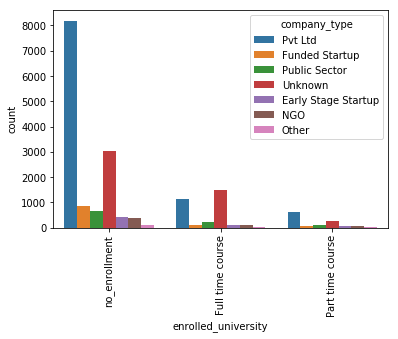

In [172]:
plt.xticks(rotation=90)
sns.countplot('enrolled_university', data=df_raw, hue='company_type')

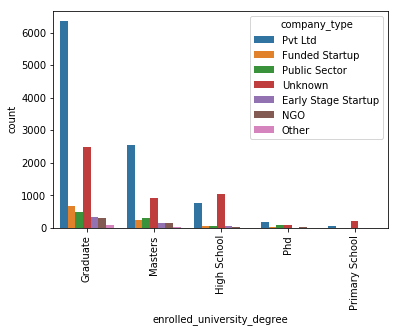

In [173]:
plt.xticks(rotation=90)
sns.countplot('enrolled_university_degree', data=df_raw, hue='company_type')

In [258]:
df_raw['major_discipline'].fillna('Unknown', axis=0, inplace=True)
df_test['major_discipline'].fillna('Unknown', axis=0, inplace=True)

df_raw['enrolled_university'].fillna('no_enrollment', axis=0, inplace=True)
df_test['enrolled_university'].fillna('no_enrollment', axis=0, inplace=True)

df_raw['enrolled_university_degree'].fillna('Graduate', axis=0, inplace=True)
df_test['enrolled_university_degree'].fillna('Graduate', axis=0, inplace=True)

In [268]:
df_test['last_new_job'].fillna(0,axis=0,inplace=True)

In [269]:
df_test.isnull().sum().sort_values(ascending=False).head(10)/len(df_test)

company_size                  0.269689
enroll_deg__major_in          0.000000
is_dev_21_30                  0.000000
city_development_index        0.000000
gender                        0.000000
relevent_experience           0.000000
enrolled_university           0.000000
enrolled_university_degree    0.000000
major_discipline              0.000000
experience                    0.000000
dtype: float64

In [263]:
df_raw.isnull().sum().sort_values(ascending=False).head(10)/len(df_raw)

company_size                  0.260308
enroll_deg__major_in          0.000000
gender__major_in              0.000000
city_development_index        0.000000
gender                        0.000000
relevent_experience           0.000000
enrolled_university           0.000000
enrolled_university_degree    0.000000
major_discipline              0.000000
experience                    0.000000
dtype: float64

## start here

In [282]:
X_train = df_raw.drop(categorical_features,axis=1)  #numeric ones
X_test  = df_test.drop(categorical_features,axis=1) #numeric ones

In [283]:
%%time
N_COMP = 10

print("\nStart decomposition process...")
print("PCA")
pca = PCA(n_components=N_COMP, random_state=17)
pca_results_X_train = pca.fit_transform(X_train)
pca_results_X_test = pca.transform(X_test)


Start decomposition process...
PCA
Wall time: 981 ms


In [284]:
%%time
print("Append decomposition components to datasets...")

for i in range(1, N_COMP + 1):
    X_train['pca_' + str(i)] = pca_results_X_train[:, i - 1]
    X_test['pca_' + str(i)] = pca_results_X_test[:, i - 1]

Append decomposition components to datasets...
Wall time: 12 ms


In [288]:
def prepare(data_orig):
    data = pd.DataFrame()
    data['mean'] = data_orig.mean(axis=1)
    data['std'] = data_orig.std(axis=1)
    data['min'] = data_orig.min(axis=1)
    data['max'] = data_orig.max(axis=1)
    data['number_of_different'] = data_orig.nunique(axis=1)               # Number of diferent values in a row.
    data['non_zero_count'] = data_orig.fillna(0).astype(bool).sum(axis=1) # Number of non zero values (e.g. transaction count)
    return data

# Replace 0 with NaN to ignore them.
X_test_stats = prepare(X_test.replace(0,np.nan))
X_train_stats = prepare(X_train.replace(0, np.nan))

In [289]:
from sklearn.cluster import KMeans

flist = [x for x in X_train.columns]

flist_kmeans = []
for ncl in range(2,11):
    cls = KMeans(n_clusters=ncl)
    cls.fit_predict(X_train[flist].values)
    X_train['kmeans_cluster_'+str(ncl)] = cls.predict(X_train[flist].values)
    X_test['kmeans_cluster_'+str(ncl)] = cls.predict(X_test[flist].values)
    flist_kmeans.append('kmeans_cluster_'+str(ncl))
print(flist_kmeans)

['kmeans_cluster_2', 'kmeans_cluster_3', 'kmeans_cluster_4', 'kmeans_cluster_5', 'kmeans_cluster_6', 'kmeans_cluster_7', 'kmeans_cluster_8', 'kmeans_cluster_9', 'kmeans_cluster_10']


In [290]:
X_train_stack, X_test_stack = np.hstack((X_train, X_train_stats)), np.hstack((X_test, X_test_stats))

In [33]:
X_train_stack, X_test_stack = np.hstack((stack_train, train_67)), np.hstack((stack_test, test_67))

In [34]:
params = {}
params['booster'] = 'gbtree'
params["objective"] = "binary:logistic"
# params['eval_metric'] = 'logloss'
params['eval_metric'] = 'auc'
params["eta"] = 0.1 #0.03
params["subsample"] = .7 #.85 was tried before
params["silent"] = 0
params['verbose'] = 1
params["max_depth"] = 8
params["seed"] = 1
params["max_delta_step"] = 4
params['scale_pos_weight'] =  0.13208780434664197
params["gamma"] = .6 #.5 #.1 #.2
params['colsample_bytree'] = 0.7
params['nrounds'] = 1000 #3600 #2000 #4000 #using lower no for demo
#params['max_leaves'] = 511
#params['verbose_eval'] = 50

In [35]:
model_xgb, p_train, p_test  = mlcrate.xgb.train_kfold(params, X_train_stack, target, X_test_stack\
                                                       , folds = 7,skip_checks = True, stratify=target, print_imp='final')

[mlcrate] Training 7 stratified XGBoost models on training set (18359, 32) with test set (15021, 32)
[mlcrate] Running fold 0, 15735 train samples, 2624 validation samples
[0]	train-auc:0.610262	valid-auc:0.603539
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.611687	valid-auc:0.602776
[2]	train-auc:0.625767	valid-auc:0.627222
[3]	train-auc:0.634295	valid-auc:0.631425
[4]	train-auc:0.644069	valid-auc:0.647621
[5]	train-auc:0.644902	valid-auc:0.648802
[6]	train-auc:0.645907	valid-auc:0.650127
[7]	train-auc:0.646452	valid-auc:0.649835
[8]	train-auc:0.647274	valid-auc:0.6491
[9]	train-auc:0.659563	valid-auc:0.659745
[10]	train-auc:0.660092	valid-auc:0.657501
[11]	train-auc:0.661307	valid-auc:0.662217
[12]	train-auc:0.662083	valid-auc:0.662668
[13]	train-auc:0.661966	valid-auc:0.662526
[14]	train-auc:0.662003	valid-auc:0.662717
[15]	train-auc:0.672621	valid-auc:0.668754
[16]	trai

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 5s - running score 0.675069
[mlcrate] Running fold 1, 15735 train samples, 2624 validation samples
[0]	train-auc:0.589674	valid-auc:0.609368
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.62757	valid-auc:0.654881
[2]	train-auc:0.64091	valid-auc:0.674641
[3]	train-auc:0.642562	valid-auc:0.676968
[4]	train-auc:0.644801	valid-auc:0.68056
[5]	train-auc:0.645237	valid-auc:0.680553
[6]	train-auc:0.645439	valid-auc:0.680698
[7]	train-auc:0.654119	valid-auc:0.686902
[8]	train-auc:0.66123	valid-auc:0.686155
[9]	train-auc:0.661265	valid-auc:0.68564
[10]	train-auc:0.662614	valid-auc:0.685775
[11]	train-auc:0.663505	valid-auc:0.685954
[12]	train-auc:0.663372	valid-auc:0.686443
[13]	train-auc:0.663579	valid-auc:0.686352
[14]	train-auc:0.663454	valid-auc:0.686267
[15]	train-auc:0.663717	valid-auc:0.686787
[16]	train-auc:0.665199	valid-auc:0.685499


[75]	train-auc:0.820631	valid-auc:0.681445
[76]	train-auc:0.821451	valid-auc:0.679747
[77]	train-auc:0.82318	valid-auc:0.679664
[78]	train-auc:0.82393	valid-auc:0.680065
[79]	train-auc:0.827614	valid-auc:0.680367
[80]	train-auc:0.830513	valid-auc:0.678987
[81]	train-auc:0.832272	valid-auc:0.676959
[82]	train-auc:0.833147	valid-auc:0.67669
[83]	train-auc:0.836183	valid-auc:0.676657
[84]	train-auc:0.838192	valid-auc:0.674976
[85]	train-auc:0.839677	valid-auc:0.676337
[86]	train-auc:0.842163	valid-auc:0.675813
[87]	train-auc:0.842686	valid-auc:0.675834
[88]	train-auc:0.847023	valid-auc:0.674002
[89]	train-auc:0.84915	valid-auc:0.673607
[90]	train-auc:0.850807	valid-auc:0.673223
[91]	train-auc:0.852438	valid-auc:0.671735
[92]	train-auc:0.855603	valid-auc:0.669217
[93]	train-auc:0.856955	valid-auc:0.669928
Stopping. Best iteration:
[43]	train-auc:0.746579	valid-auc:0.69482

[mlcrate] Finished training fold 2 - took 5s - running score 0.6889643333333333
[mlcrate] Running fold 3, 15737 train 

[79]	train-auc:0.82006	valid-auc:0.639505
[80]	train-auc:0.821217	valid-auc:0.640835
Stopping. Best iteration:
[30]	train-auc:0.706068	valid-auc:0.655199

[mlcrate] Finished training fold 4 - took 6s - running score 0.673685
[mlcrate] Running fold 5, 15737 train samples, 2622 validation samples
[0]	train-auc:0.617167	valid-auc:0.601804
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.642762	valid-auc:0.627823
[2]	train-auc:0.644401	valid-auc:0.631204
[3]	train-auc:0.648819	valid-auc:0.634766
[4]	train-auc:0.651324	valid-auc:0.638614
[5]	train-auc:0.651296	valid-auc:0.638046
[6]	train-auc:0.65218	valid-auc:0.637454
[7]	train-auc:0.656175	valid-auc:0.635014
[8]	train-auc:0.657227	valid-auc:0.636454
[9]	train-auc:0.657201	valid-auc:0.636709
[10]	train-auc:0.657615	valid-auc:0.636739
[11]	train-auc:0.659172	valid-auc:0.638671
[12]	train-auc:0.659135	valid-auc:0.638897
[13]	train-au

[80]	train-auc:0.82485	valid-auc:0.663782
[81]	train-auc:0.827209	valid-auc:0.665227
[82]	train-auc:0.829144	valid-auc:0.664217
[83]	train-auc:0.831815	valid-auc:0.662836
[84]	train-auc:0.832206	valid-auc:0.662424
[85]	train-auc:0.834265	valid-auc:0.662916
[86]	train-auc:0.836778	valid-auc:0.662213
[87]	train-auc:0.838666	valid-auc:0.661718
[88]	train-auc:0.840203	valid-auc:0.661087
[89]	train-auc:0.841724	valid-auc:0.660848
[90]	train-auc:0.843744	valid-auc:0.660664
[91]	train-auc:0.847277	valid-auc:0.661182
[92]	train-auc:0.849616	valid-auc:0.662085
[93]	train-auc:0.851121	valid-auc:0.66248
[94]	train-auc:0.852751	valid-auc:0.662537
[95]	train-auc:0.854391	valid-auc:0.662752
[96]	train-auc:0.855938	valid-auc:0.663607
[97]	train-auc:0.857686	valid-auc:0.664285
[98]	train-auc:0.860355	valid-auc:0.662694
[99]	train-auc:0.862614	valid-auc:0.662459
[100]	train-auc:0.863344	valid-auc:0.662029
[101]	train-auc:0.865265	valid-auc:0.660631
[102]	train-auc:0.866996	valid-auc:0.661501
[103]	trai

In [36]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\AV_Stud_2\\sample_submission.csv')
    submit = sample.copy()
    submit['target'] = probs
    return submit

In [37]:
submit = make_submission(p_test)
submit.to_csv(f'{PATH}\\AV_Stud_2\\xgb_remake_2.csv', index=False)
submit.head(2)

# np.save(f'{PATH}\\AV_Stud_2\\xgb_oof_1207.npy', p_train)
# np.save(f'{PATH}\\AV_Stud_2\\raw_train_dummy_impact_train67.npy', X_train_stack)
# np.save(f'{PATH}\\AV_Stud_2\\raw_test_dummy_impact_test67.npy', X_test_stack)

# np.save(f'{PATH}\\AV_Stud_2\\train_no_cat_with_std_pca.npy', df_raw)
# np.save(f'{PATH}\\AV_Stud_2\\test_no_cat_with_std_pca.npy', df_test)

,enrollee_id,target
0,16548,0.212668
1,12036,0.021563


In [272]:
df_raw.to_csv(f'{PATH}\\AV_Stud_2\\clean_train_1207.csv', index=False)
df_test.to_csv(f'{PATH}\\AV_Stud_2\\clean_test_1207.csv', index=False)

In [4]:
train = np.load(f'{PATH}\\AV_Stud_2\\train_dummy_impact_train67.npy')

In [5]:
np.savetxt(f'{PATH}\\AV_Stud_2\\train_dummy_impact_train67.csv',train, delimiter=',')

In [6]:
test = np.load(f'{PATH}\\AV_Stud_2\\test_dummy_impact_test67.npy')
np.savetxt(f'{PATH}\\AV_Stud_2\\test_dummy_impact_train67.csv',test, delimiter=',')

In [15]:
clf_et = ExtraTreesClassifier(criterion='entropy',max_leaf_nodes=0,n_estimators=500,\
                             min_impurity_split=0.0001,n_jobs=4,max_features=0.7,max_depth=8,min_samples_leaf=1,\
                             class_weight='balanced')

In [40]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.05],
    'n_estimators': [100, 150, 250, 500],
    'num_leaves': [255,511],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [.7, 0.74, 0.75, 0.76, .85],
    'subsample' : [0.7,0.75, .8],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = -1, # Updated from 'nthread' 
          silent = False,
          max_depth = 8,
          max_bin = 128, 
          subsample_for_bin = 1,
          subsample = .7, 
          subsample_freq = 1, 
          min_split_gain = .5,  
          scale_pos_weight = 0.1346)

# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [41]:
# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5, n_jobs=-1)
# Run the grid
grid.fit(X_train_stack, target)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 18.0min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 255, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.867912195653


In [45]:
params = {}

Fitting with params: 
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'num_leaves': 255, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
Fitting model 0


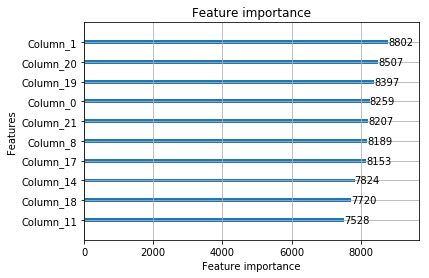

Fitting model 1


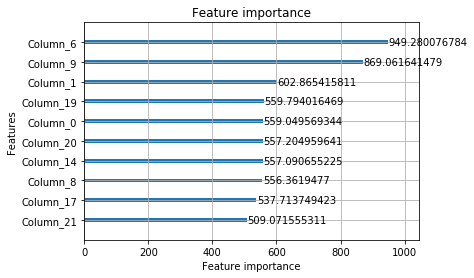

In [46]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = 0.05 
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

print('Fitting with params: ')
print(params)

# Kit k models with early-stopping on different training/validation splits
k = 2;
predsValid = 0 
predsTrain = 0
predsTest = 0
l = ['split','gain']
for i in range(0, k): 
    print('Fitting model', i)
    
    # Prepare the data set for fold
    X_train, X_test, y_train, y_test = train_test_split(X_train_stack, target, test_size=0.2, random_state=7, shuffle=True)
    
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_test, label=y_test)
    
    # Train     
    gbm = lgb.train(params,
                    d_train, 
                    1000, 
                    verbose_eval=1)

    # Plot importance
    lgb.plot_importance(gbm,max_num_features=10, importance_type=l[i])
    plt.show()